## **Step 1 : import and load dataset**

In [ ]:
import pandas as pd

# loading the CSVs

df_fake = pd.read_csv('Fake.csv')
df_true = pd.read_csv('True.csv')

# adding label

df_fake['label'] = 0 # fake
df_true['label'] = 1 # real

# combine

df = pd.concat([df_fake, df_true], ignore_index=True)

# shuffle

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# show head

df.head()


,title,text,subject,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",0
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",1
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",1
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",0
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",1


In [ ]:
# show count

df['label'].value_counts()

,count
label,
0,23481
1,21417


### Step 2 Basic EDA (Exploratory Data Analysis)

In [ ]:
print("Total samples:", len(df))
print("Fake count:", (df['label']==0).sum())
print("Real count:", (df['label']==1).sum())
print("Subjects:", df['subject'].unique())

Total samples: 44898
Fake count: 23481
Real count: 21417
Subjects: ['US_News' 'politicsNews' 'News' 'Government News' 'left-news' 'worldnews'
 'politics' 'Middle-east']


# **Phase 2** **Text Preprocessing & Deception Feature Engineering**

In [ ]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
  text = text.lower() #lowercase
  text = re.sub(r'\n', ' ', text)  # remove line breaks
  text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # remove punctuation
  text = ' '.join(word for word in text.split() if word not in stop_words)  # remove stopwords
  return text

df['clean_text'] = df['text'].apply(clean_text)
df['clean_title'] = df['title'].apply(clean_text)

df[['text', 'clean_text']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,text,clean_text
0,"21st Century Wire says Ben Stein, reputable pr...",21st century wire says ben stein reputable pro...
1,WASHINGTON (Reuters) - U.S. President Donald T...,washington reuters us president donald trump r...
2,(Reuters) - Puerto Rico Governor Ricardo Rosse...,reuters puerto rico governor ricardo rossello ...
3,"On Monday, Donald Trump once again embarrassed...",monday donald trump embarrassed country accide...
4,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",glasgow scotland reuters us presidential candi...


In [ ]:
import numpy as np
from textblob import TextBlob

def count_punctuation(text):
    return len(re.findall(r'[!?]', text))

def caps_ratio(text):
    caps = sum(1 for c in text if c.isupper())
    total = len(text)
    return caps / total if total > 0 else 0

def sentiment_polarity(text):
    return TextBlob(text).sentiment.polarity

def avg_word_length(text):
    words = text.split()
    return np.mean([len(w) for w in words]) if len(words) > 0 else 0

# Apply features
df['punctuation_count'] = df['text'].apply(count_punctuation)
df['caps_ratio'] = df['text'].apply(caps_ratio)
df['sentiment'] = df['text'].apply(sentiment_polarity)
df['avg_word_len'] = df['text'].apply(avg_word_length)

df[['text', 'punctuation_count', 'caps_ratio', 'sentiment', 'avg_word_len']].head()


,text,punctuation_count,caps_ratio,sentiment,avg_word_len
0,"21st Century Wire says Ben Stein, reputable pr...",0,0.101167,0.083333,4.988304
1,WASHINGTON (Reuters) - U.S. President Donald T...,0,0.045228,0.086597,5.249027
2,(Reuters) - Puerto Rico Governor Ricardo Rosse...,0,0.031385,-0.005044,5.023026
3,"On Monday, Donald Trump once again embarrassed...",0,0.044212,-0.011161,5.704918
4,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",0,0.039847,0.039347,4.928166


## **PHASE 3: Split → TF-IDF → Logistic Regression → Baseline Evaluation**

In [ ]:
from sklearn.model_selection import train_test_split

# Text input = title + body (cleaned)
X_text = (df['clean_title'].fillna('') + ' ' + df['clean_text'].fillna('')).astype(str)
y = df['label'].astype(int)

# 80/10/10 split (stratified)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_text, y, test_size=0.2, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

len(X_train), len(X_val), len(X_test)


(35918, 4490, 4490)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=5,
    max_df=0.9,
    strip_accents='unicode'
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf   = tfidf.transform(X_val)
X_test_tfidf  = tfidf.transform(X_test)

X_train_tfidf.shape, X_val_tfidf.shape, X_test_tfidf.shape


((35918, 275432), (4490, 275432), (4490, 275432))

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(
    max_iter=1000,
    n_jobs=-1,
    class_weight='balanced',  # helpful if slight imbalance
    solver='liblinear'        # robust for sparse features
)

logreg.fit(X_train_tfidf, y_train)

# Validate
from sklearn.metrics import f1_score, accuracy_score

val_pred = logreg.predict(X_val_tfidf)
val_acc = accuracy_score(y_val, val_pred)
val_f1 = f1_score(y_val, val_pred, average='macro')
val_acc, val_f1


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


(0.9902004454342984, 0.9901821168620304)

              precision    recall  f1-score   support

           0      0.994     0.987     0.990      2348
           1      0.986     0.993     0.990      2142

    accuracy                          0.990      4490
   macro avg      0.990     0.990     0.990      4490
weighted avg      0.990     0.990     0.990      4490



<Figure size 640x480 with 0 Axes>

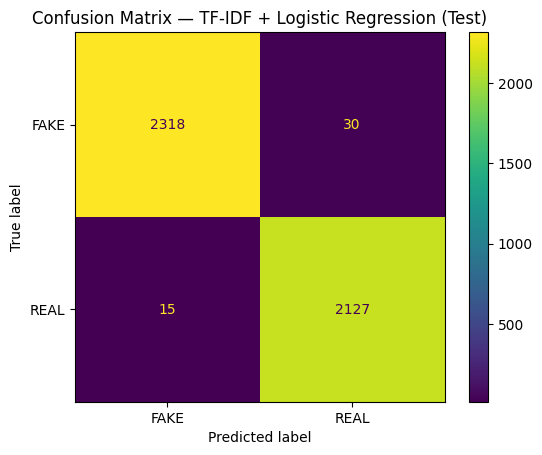

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

test_pred = logreg.predict(X_test_tfidf)

print(classification_report(y_test, test_pred, digits=3))

cm = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['FAKE','REAL'])
fig = plt.figure()
disp.plot(values_format='d')
plt.title('Confusion Matrix — TF-IDF + Logistic Regression (Test)')
plt.show()


In [ ]:
## for screenshots

import numpy as np

feature_names = np.array(tfidf.get_feature_names_out())
coefs = logreg.coef_[0]

# Top tokens pushing toward REAL (label=1)
top_real_idx = np.argsort(coefs)[-20:]
top_real = list(zip(feature_names[top_real_idx], coefs[top_real_idx]))

# Top tokens pushing toward FAKE (label=0)
top_fake_idx = np.argsort(coefs)[:20]
top_fake = list(zip(feature_names[top_fake_idx], coefs[top_fake_idx]))

print("Top REAL-indicative terms:")
for t, w in reversed(top_real):
    print(f"{t:25s} {w:.3f}")

print("\nTop FAKE-indicative terms:")
for t, w in top_fake:
    print(f"{t:25s} {w:.3f}")


Top REAL-indicative terms:
reuters                   21.866
said                      19.909
washington reuters        8.866
trumps                    8.231
reuters us                5.656
wednesday                 5.292
us                        5.120
president donald          4.977
tuesday                   4.751
washington                4.749
republican                4.735
thursday                  4.733
friday                    4.410
minister                  4.382
us president              4.292
monday                    4.115
said statement            3.706
presidential              3.309
nov                       3.284
spokesman                 3.134

Top FAKE-indicative terms:
video                     -10.715
via                       -7.636
obama                     -5.915
hillary                   -5.425
image                     -5.119
america                   -5.101
gop                       -4.908
president trump           -4.746
even                      -4.515
like 

# **PHASE 4: Fusion Model (TF-IDF + Deception Features) + Topic Vulnerability**

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix

dense_cols = ['punctuation_count','caps_ratio','sentiment','avg_word_len']

# Split dense features parallel to text splits (match indices)
dense_all = df[dense_cols].values
dense_train = dense_all[y.index.isin(y_train.index)]  # just to be safe if indices changed
dense_val   = dense_all[y.index.isin(y_val.index)]
dense_test  = dense_all[y.index.isin(y_test.index)]

# More robust way: slice by position using the original splits
dense_train = df.loc[X_train.index, dense_cols].values
dense_val   = df.loc[X_val.index, dense_cols].values
dense_test  = df.loc[X_test.index, dense_cols].values

scaler = StandardScaler()
dense_train_scaled = scaler.fit_transform(dense_train)
dense_val_scaled   = scaler.transform(dense_val)
dense_test_scaled  = scaler.transform(dense_test)

# Convert dense → sparse for hstack
dense_train_sp = csr_matrix(dense_train_scaled)
dense_val_sp   = csr_matrix(dense_val_scaled)
dense_test_sp  = csr_matrix(dense_test_scaled)

# Concatenate with TF-IDF
X_train_fused = hstack([X_train_tfidf, dense_train_sp])
X_val_fused   = hstack([X_val_tfidf,   dense_val_sp])
X_test_fused  = hstack([X_test_tfidf,  dense_test_sp])

X_train_fused.shape, X_val_fused.shape, X_test_fused.shape


((35918, 275436), (4490, 275436), (4490, 275436))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

logreg_fused = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    solver='liblinear'  # handles sparse well
)

logreg_fused.fit(X_train_fused, y_train)

# Validation metrics
val_pred_fused = logreg_fused.predict(X_val_fused)
val_acc_fused = accuracy_score(y_val, val_pred_fused)
val_f1_fused  = f1_score(y_val, val_pred_fused, average='macro')
val_acc_fused, val_f1_fused


(0.9884187082405346, 0.9883974923317502)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Baseline test metrics already computed as test_pred
test_pred_fused = logreg_fused.predict(X_test_fused)

rep_base  = classification_report(y_test, test_pred, output_dict=True)
rep_fused = classification_report(y_test, test_pred_fused, output_dict=True)

compare = pd.DataFrame({
    'Metric'       : ['Accuracy','Macro-F1'],
    'Baseline'     : [rep_base['accuracy'], rep_base['macro avg']['f1-score']],
    'Fused'        : [rep_fused['accuracy'], rep_fused['macro avg']['f1-score']],
    'Δ (Fused-Base)': [rep_fused['accuracy']-rep_base['accuracy'],
                       rep_fused['macro avg']['f1-score']-rep_base['macro avg']['f1-score']]
})
compare


,Metric,Baseline,Fused,Δ (Fused-Base)
0,Accuracy,0.989978,0.989532,-0.000445
1,Macro-F1,0.989960,0.989513,-0.000447


<Figure size 640x480 with 0 Axes>

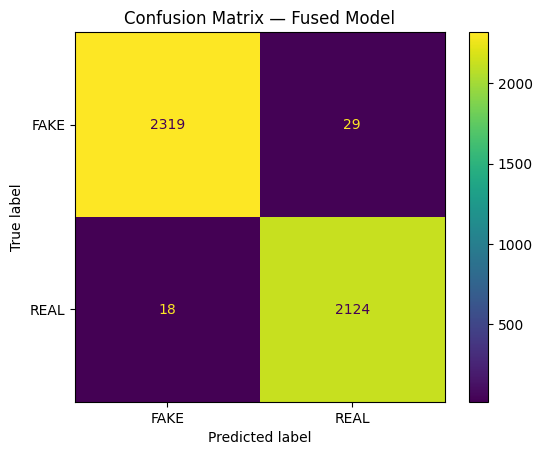

In [ ]:
# Confusion matrix for fused model
cm_fused = confusion_matrix(y_test, test_pred_fused)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_fused, display_labels=['FAKE','REAL'])
fig = plt.figure()
disp.plot(values_format='d')
plt.title('Confusion Matrix — Fused Model')
plt.show()


In [ ]:
from sklearn.metrics import f1_score

# Collect subject column for the test split
subjects_test = df.loc[X_test.index, 'subject'].fillna('Unknown')

# Compute Macro-F1 per subject for each model
rows = []
for subj in subjects_test.unique():
    idx = (subjects_test == subj)
    if idx.sum() < 20:  # skip tiny slices
        continue
    f1_base  = f1_score(y_test[idx], test_pred[idx], average='macro')
    f1_fused = f1_score(y_test[idx], test_pred_fused[idx], average='macro')
    rows.append([subj, int(idx.sum()), f1_base, f1_fused, f1_fused - f1_base])

slice_df = pd.DataFrame(rows, columns=['Subject','Support','F1_Base','F1_Fused','ΔF1'])
slice_df.sort_values('F1_Fused', ascending=False, inplace=True)
slice_df


,Subject,Support,F1_Base,F1_Fused,ΔF1
2,worldnews,1027,0.499269,0.499513,0.000244
0,News,937,0.499466,0.498930,-0.000535
1,left-news,465,0.497297,0.498382,0.001085
5,US_News,78,0.496774,0.496774,0.000000
7,Middle-east,78,0.496774,0.496774,0.000000
3,politicsNews,1115,0.497295,0.496387,-0.000908
6,Government News,140,0.489051,0.494585,0.005534
4,politics,650,0.494163,0.493375,-0.000789


In [ ]:
# LogReg coefficients align to [tfidf features..., dense features...]
num_tfidf = X_train_tfidf.shape[1]
coef = logreg_fused.coef_[0]

handcrafted_weights = dict(zip(dense_cols, coef[num_tfidf: num_tfidf + len(dense_cols)]))
handcrafted_weights


{'punctuation_count': np.float64(-1.2813418924602857),
 'caps_ratio': np.float64(-0.05350825420030463),
 'sentiment': np.float64(-0.0024715446603002338),
 'avg_word_len': np.float64(0.0016640632176994452)}

# **PHASE 5: Explainability + Error Analysis + Final Report Assembly + GitHub Checklist**

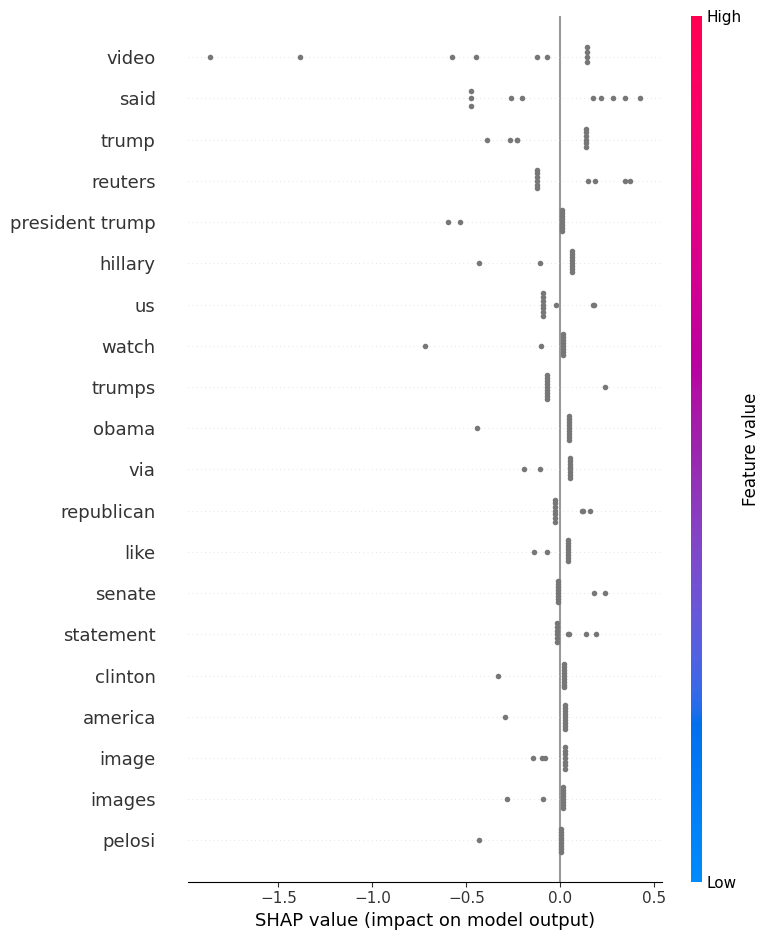

In [ ]:
import shap

explainer = shap.LinearExplainer(logreg, X_train_tfidf, feature_names=tfidf.get_feature_names_out())
shap_values = explainer.shap_values(X_test_tfidf[:10])  # sample 10 rows

shap.summary_plot(shap_values, X_test_tfidf[:10], feature_names=tfidf.get_feature_names_out())


In [ ]:
# @title
mis_idx = [i for i in range(len(y_test)) if test_pred[i] != y_test.iloc[i]]
mis_df = df.loc[X_test.index].iloc[mis_idx][['title','text','label','subject']].head(5)
mis_df


,title,text,label,subject
24199,JUST IN: TRUMP ENDS FREE MONEY TRAIN After Pak...,The Trump administration on Friday announced t...,0,politics
26630,CHINESE IMMIGRANT OWES MILLIONS FOR SELLING CO...,Counterfeiting is illegal by the way and shoul...,0,politics
39438,PHILIPPINES: 2016 Washington’s Fury as Philipp...,Duterte takes clear lead in Philippine electi...,0,Middle-east
5525,U.S. APOLOGIZES FOR HUMAN RIGHTS VIOLATIONS AT...,Obama s apology tour for the greatest country ...,0,politics
44856,HUNGARY’S BADASS PRIME MINISTER Responds To Th...,German Social Democrat leader Martin Schulz sa...,0,politics


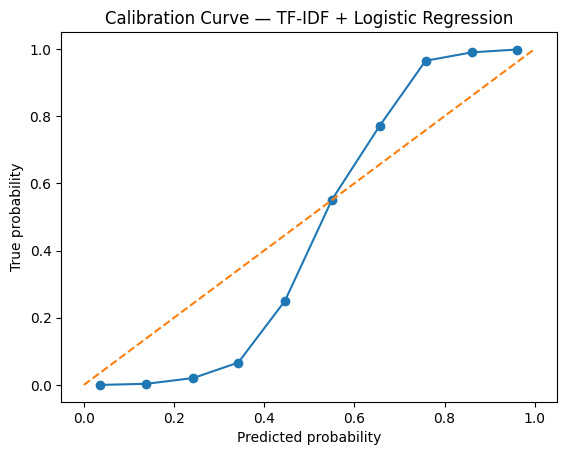

In [ ]:
from sklearn.calibration import calibration_curve

probs = logreg.predict_proba(X_test_tfidf)[:,1]
true, pred = calibration_curve(y_test, probs, n_bins=10)

import matplotlib.pyplot as plt
plt.plot(pred, true, marker='o')
plt.plot([0,1],[0,1],'--')
plt.xlabel('Predicted probability')
plt.ylabel('True probability')
plt.title('Calibration Curve — TF-IDF + Logistic Regression')
plt.show()
